In [1]:
import pandas as pd; pd.set_option('display.max_rows', 500)

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import torchvision

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

### Synchronizing actions and frames.
Actions come in at a lower frequency than frames, so we have to match them up as good as possible based on timestamp. This increases length of actions to match that of frames

In [2]:
#"DJIFlightRecord_2018-09-07_[11-36-38][1]-TxtLogToCsv.csv"
log = "DJIFlightRecord_2018-09-08_15-08-46-TxtLogToCsv.csv"

actions_df = pd.read_csv("../../logs/"+log).fillna(0); len(actions_df)

/home/rugilman/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (96,271) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4077

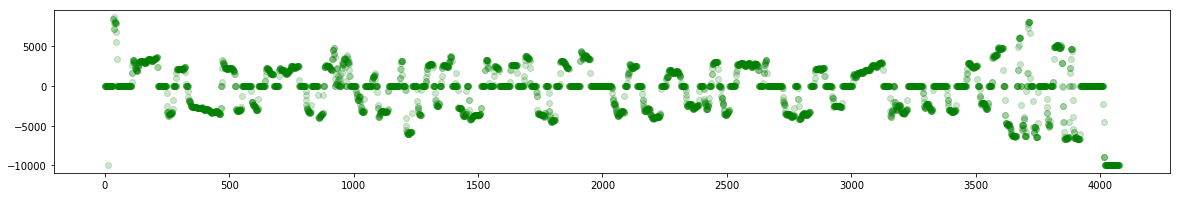

In [3]:
# Testing raw data from 256

seq = actions_df["RC.throttle"]
# Plotting a random z component over time
plt.figure(figsize=(20,3))

# all models
plt.plot(np.arange(len(seq)), seq, 'go', alpha=0.2, markerfacecolor='green')

plt.show()

In [4]:
cols = ["CAMERA_INFO.videoRecordTime", "RC.aileron", "RC.elevator", "RC.throttle", "RC.rudder"]

actions_df = actions_df[actions_df["CAMERA_INFO.recordState"]=="Starting"][cols]; 
actions_df["action_ix"]=range(len(actions_df)); len(actions_df)

3910

In [5]:
actions_df

CAMERA_INFO.videoRecordTime  RC.aileron  RC.elevator  RC.throttle  \
90                              0         0.0          0.0          0.0   
91                              0         0.0          0.0          0.0   
92                              0         0.0          0.0          0.0   
93                              0         0.0          0.0          0.0   
94                              0         0.0          0.0          0.0   
95                              0         0.0          0.0          0.0   
96                              0         0.0          0.0          0.0   
97                              1         0.0          0.0          0.0   
98                              1         0.0          0.0          0.0   
99                              1         0.0          0.0          0.0   
100                             1         0.0          0.0          0.0   
101                             1         0.0          0.0          0.0   
102                             1         0.0          0.0          0.0   
103                             1         0.0          0.0          0.0   
104                             1         0.0          0.0          0.0   
105                             1         0.0          0.0          0.0   
106                             1         0.0          0.0          0.0   
107                             2         0.0          0.0         45.0   
108                             2         0.0          0.0        576.0   
109                             2         0.0          0.0       1682.0   
110                             2         0.0          0.0       1682.0   
111                             2         0.0          0.0       2682.0   
112                             2         0.0          0.0       3061.0   
113                             2         0.0          0.0       3348.0   
114                             2         0.0          0.0       3348.0   
115                             2         0.0          0.0       3348.0   
116                             2         0.0          0.0       3242.0   
117                             3         0.0          0.0       3121.0   
118                             3         0.0          0.0       3030.0   
119                             3         0.0          0.0       2894.0   
120                             3         0.0          0.0       2894.0   
121                             3         0.0          0.0       2621.0   
122                             3         0.0          0.0       2303.0   
123                             3         0.0          0.0       2303.0   
124                             3         0.0          0.0       2242.0   
125                             3         0.0          0.0       2076.0   
126                             3         0.0          0.0       1970.0   
127                             4         0.0          0.0       1985.0   
128                             4         0.0          0.0       1955.0   
129                             4         0.0          0.0       1939.0   
130                             4         0.0          0.0       1955.0   
131                             4         0.0          0.0       2045.0   
132                             4         0.0          0.0       2227.0   
133                             4         0.0          0.0       2500.0   
134                             4         0.0          0.0       2500.0   
135                             4         0.0          0.0       2606.0   
136                             4         0.0          0.0       2833.0   
137                             4         0.0          0.0       2939.0   
138                             5         0.0          0.0       3030.0   
139                             5         0.0          0.0       3030.0   
140                             5         0.0          0.0       3136.0   
141                             5         0.0          0.0       3167.0   
142                            

In [29]:
# Reading in FRAME timestamps
vid_id = "DJI_0007_lr"
timestamps = pd.read_csv(vid_id+"_frame_timestamps.csv"); print(len(timestamps),'\n', timestamps.tail())

11722 
        timestamp
11717     390991
11718     391024
11719     391057
11720     391091
11721     391124


In [43]:
# Estimating ACTION timestamps
actions_df["timestamp"] = np.round(np.linspace(0, timestamps.iloc[-1], len(actions_df)), 0).astype(int)

In [44]:
actions_df["timestamp"] += 1000; # Adding a second here seems to line up actions better

In [45]:
# Merging ACTION and FRAME on closest timestamp
a = pd.merge_asof(left=timestamps, right=actions_df, on="timestamp").fillna(0); a

timestamp  CAMERA_INFO.videoRecordTime  RC.aileron  RC.elevator  \
0             33                          0.0         0.0          0.0   
1             67                          0.0         0.0          0.0   
2            100                          0.0         0.0          0.0   
3            133                          0.0         0.0          0.0   
4            167                          0.0         0.0          0.0   
5            200                          0.0         0.0          0.0   
6            234                          0.0         0.0          0.0   
7            267                          0.0         0.0          0.0   
8            300                          0.0         0.0          0.0   
9            334                          0.0         0.0          0.0   
10           367                          0.0         0.0          0.0   
11           400                          0.0         0.0          0.0   
12           434                          0.0         0.0          0.0   
13           467                          0.0         0.0          0.0   
14           500                          0.0         0.0          0.0   
15           534                          0.0         0.0          0.0   
16           567                          0.0         0.0          0.0   
17           601                          0.0         0.0          0.0   
18           634                          0.0         0.0          0.0   
19           667                          0.0         0.0          0.0   
20           701                          0.0         0.0          0.0   
21           734                          0.0         0.0          0.0   
22           767                          0.0         0.0          0.0   
23           801                          0.0         0.0          0.0   
24           834                          0.0         0.0          0.0   
25           868                          0.0         0.0          0.0   
26           901                          0.0         0.0          0.0   
27           934                          0.0         0.0          0.0   
28           968                          0.0         0.0          0.0   
29          1001                          0.0         0.0          0.0   
30          1034                          0.0         0.0          0.0   
31          1068                          0.0         0.0          0.0   
32          1101                          0.0         0.0          0.0   
33          1134                          0.0         0.0          0.0   
34          1168                          0.0         0.0          0.0   
35          1201                          0.0         0.0          0.0   
36          1235                          0.0         0.0          0.0   
37          1268                          0.0         0.0          0.0   
38          1301                          0.0         0.0          0.0   
39          1335                          0.0         0.0          0.0   
40          1368                          0.0         0.0          0.0   
41          1401                          0.0         0.0          0.0   
42          1435                          0.0         0.0          0.0   
43          1468                          0.0         0.0          0.0   
44          1502                          0.0         0.0          0.0   
45          1535                          0.0         0.0          0.0   
46          1568                          0.0         0.0          0.0   
47          1602                          0.0         0.0          0.0   
48          1635                          0.0         0.0          0.0   
49          1668                          0.0         0.0          0.0   
50          1702                          1.0         0.0          0.0   
51          1735                          1.0         0.0          0.0   
52          1768                          1.0         0.0          0.0   
53         

In [46]:
# Saving entire sequence of actions, to be loaded together w z seqs. 

actions = torch.tensor(a["RC.throttle"]).unsqueeze(1)
torch.save(actions, "actions_sequential_9.10.pt")

In [36]:
actions.shape

torch.Size([11722, 1])

In [5]:
# Loading z seqs from VAE. Same shape, essence as sine waves above.

#"z_seq_sequential_9.7.pt"
z_seq_file = "z_seq_sequential_9.8.pt"

z_seq = torch.load(z_seq_file); print(z_seq.shape)

df_vid = pd.DataFrame({"frame":range(len(z_seq))}); df_vid.head()

(10194, 100)


frame
0      0
1      1
2      2
3      3
4      4

In [6]:
al = len(actions_df); print(al)
vl = len(df_vid); print(vl)

3910
10194


In [7]:
ls = np.linspace(0, (al), vl); print(len(ls))
j = np.round(ls, 0).astype(int); print(len(j))
df_vid["action_ix"] = j

10194
10194


In [8]:
a = pd.merge(df_vid, actions_df, how="left", on="action_ix").fillna(0); len(a)

10194

In [9]:
actions = torch.tensor(a["RC.throttle"]).unsqueeze(1)

In [44]:
# If catting to zs
# torch.cat([actions, torch.tensor(z_seq)], dim=1).shape

torch.Size([2532, 101])

In [10]:
# Saving entire sequence of actions, to be loaded together w z seqs
torch.save(actions, "actions_sequential_9.10.pt")

In [11]:
actions.shape # same size as z seqs, can be easily concatenated on. 

torch.Size([10194, 1])

In [16]:
actions_df.tail()

CAMERA_INFO.videoRecordTime  RC.aileron  RC.elevator  RC.throttle  \
3995                          390         0.0          0.0          0.0   
3996                          390         0.0          0.0          0.0   
3997                          390         0.0          0.0          0.0   
3998                          390         0.0          0.0          0.0   
3999                          390         0.0          0.0          0.0   

      RC.rudder  action_ix  
3995        0.0       3905  
3996        0.0       3906  
3997        0.0       3907  
3998        0.0       3908  
3999        0.0       3909